In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
""" setting seed for repetability of results """
np.random.seed(1)

## Data Preprocessing

In [3]:
car_data_raw = pd.read_csv("147.csv", header=-1)

In [4]:
car_data_raw.head()
car_data_raw.columns = ["Id", "Speed", "RPM", "Engine Load"]

In [5]:
""" 
RPM is on a different scale so will experiment with normalization of data
"""
car_data_raw.describe()

,Id,Speed,RPM,Engine Load
count,13726.000000,13726.000000,13726.000000,13726.000000
mean,454117.188912,28.282821,1224.099301,31.287119
std,217035.672940,22.714017,504.335148,22.677319
min,131501.000000,0.000000,0.000000,0.000000
25%,269089.250000,7.000000,894.000000,10.000000
50%,378304.500000,27.000000,1295.000000,32.000000
75%,673087.750000,47.000000,1586.000000,47.000000
max,778837.000000,200.000000,3290.000000,100.000000


In [6]:
print car_data_raw.shape
car_data_raw['Id'].nunique()
# Looks like unique id for each observation, not relevant for clustering

(13726, 4)


13726

In [7]:
list_of_relevant_cols=["Speed", "RPM", "Engine Load"]

In [8]:
# """
# Scaling the variables
# """
# from sklearn.preprocessing import MinMaxScaler
# car_data = pd.DataFrame(MinMaxScaler().fit_transform(car_data_raw[list_of_relevant_cols]))
""" 
tried with different scaling strategy like minmax, robust scaler etc
but unscaled data had best clustering performance hence sticking with that
results are easily interpretable too
"""
car_data = car_data_raw[list_of_relevant_cols]

In [9]:
car_data.head()

,Speed,RPM,Engine Load
0,7,898,44
1,7,898,44
2,1,917,32
3,1,917,32
4,0,774,38


## Clustering

In [10]:
number_of_clusters = 6 # gear reverse + 1 to 5
kmeans_object = KMeans(number_of_clusters)

In [11]:
kmeans_object.fit(car_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [12]:
labels = kmeans_object.labels_
labels

array([1, 1, 1, ..., 2, 2, 2], dtype=int32)

In [13]:
car_data['gear_labels'] = labels
car_data['gear_labels'] = car_data['gear_labels'].astype(str)
car_data.head()

,Speed,RPM,Engine Load,gear_labels
0,7,898,44,1
1,7,898,44,1
2,1,917,32,1
3,1,917,32,1
4,0,774,38,1


In [14]:
car_data['gear_labels'].value_counts()

1    4626
4    3344
0    2441
3    1962
2     885
5     468
Name: gear_labels, dtype: int64

In [15]:
centroids = kmeans_object.cluster_centers_
centroids

array([[3.12000000e+01, 1.26766462e+03, 2.86085890e+01],
       [9.22135754e+00, 8.63992218e+02, 4.10438824e+01],
       [5.94463277e+00, 2.12881356e+00, 7.31525424e+00],
       [4.79105774e+01, 1.80725345e+03, 3.09555442e+01],
       [4.37991031e+01, 1.53087115e+03, 2.53103139e+01],
       [5.07222222e+01, 2.23563248e+03, 3.82756410e+01]])

In [16]:
"""
Assumptions/Intuition
Label 2 has relatively few observations, people don't drive in reverse so often, low speed and 
very different rpm and engine load -- Reverse gear
Other gear Labels can be given in terms of the speed, higher speed higher the gear
"""
for centers in centroids:
    print "speed mean", centers[0].round(2), "rpm mean", centers[1].round(2), "engine load mean", centers[2].round(2)

speed mean 31.2 rpm mean 1267.66 engine load mean 28.61
speed mean 9.22 rpm mean 863.99 engine load mean 41.04
speed mean 5.94 rpm mean 2.13 engine load mean 7.32
speed mean 47.91 rpm mean 1807.25 engine load mean 30.96
speed mean 43.8 rpm mean 1530.87 engine load mean 25.31
speed mean 50.72 rpm mean 2235.63 engine load mean 38.28


In [17]:
"""Cluster Diagnostics """
""" Decent  silhouette score indicating good clustering health"""
from sklearn import metrics
metrics.silhouette_score(car_data[list_of_relevant_cols], labels, metric='euclidean')

0.6082419123204645

In [18]:
""" function to identify error observations as outliers """
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [19]:
""" identify outliers within each cluster"""
""" outlier percentage too high, need to put some more work in, not doing error removal """
for label in car_data['gear_labels'].unique():
    print "label",label
#     print car_data[car_data['gear_labels'] == label][["Speed", "RPM", "Engine Load"]].describe()
    car_label_data = car_data[car_data['gear_labels'] == label][["Speed", "RPM", "Engine Load"]]
    car_label_outlier = pd.DataFrame(car_label_data[["Speed", "RPM", "Engine Load"]].apply(mad_based_outlier))
    renamed_labels = ["speed_is_outlier", "rpm_is_outlier", "engine_load_is_outlier"]
    car_label_outlier.columns = renamed_labels
    car_data_combined = pd.concat([car_label_data,car_label_outlier], axis=1)
    print car_data_combined[car_data_combined[renamed_labels].any(axis=1)].shape, car_data_combined.shape

label 1
(579, 6) (4626, 6)
label 2
(181, 6) (885, 6)
label 3
(0, 6) (1962, 6)
label 4
(0, 6) (3344, 6)
label 0
(0, 6) (2441, 6)
label 5
(22, 6) (468, 6)


## Intuition based labelling

In [20]:
gear_to_label_map = {"5":"5th gear","3":"4th gear", "4":"3rd gear", "0":"2nd gear", "1":"1st gear", "2":"reverse gear"}

In [21]:
car_data['gear_labels'].replace(gear_to_label_map, inplace=True)

In [22]:
car_data['gear_labels'].value_counts()

1st gear        4626
3rd gear        3344
2nd gear        2441
4th gear        1962
reverse gear     885
5th gear         468
Name: gear_labels, dtype: int64

In [23]:
gear_count = car_data['gear_labels'].value_counts()

In [24]:
(gear_count/len(car_data)*100).round(2)

1st gear        33.70
3rd gear        24.36
2nd gear        17.78
4th gear        14.29
reverse gear     6.45
5th gear         3.41
Name: gear_labels, dtype: float64

## post clustering visualization

In [25]:
""" plotting metrics two at a time by label"""
import matplotlib.pyplot as plt
# three different scatter series so the class labels in the legend are distinct
def two_variables_with_cluster_color_simple(car_data,col_x_axis,col_y_axis):
    plt.scatter(car_data[car_data["gear_labels"]=="reverse gear"][col_x_axis], 
                car_data[car_data["gear_labels"]=="reverse gear"][col_y_axis], label='Reverse', c='black')
    plt.scatter(car_data[car_data["gear_labels"]=="1st gear"][col_x_axis], 
                car_data[car_data["gear_labels"]=="1st gear"][col_y_axis], label='1st Gear', c='blue')
    plt.scatter(car_data[car_data["gear_labels"]=="2nd gear"][col_x_axis], 
                car_data[car_data["gear_labels"]=="2nd gear"][col_y_axis], label='2nd Gear', c='lightgreen')
    plt.scatter(car_data[car_data["gear_labels"]=="3rd gear"][col_x_axis], 
                car_data[car_data["gear_labels"]=="3rd gear"][col_y_axis], label='3rd Gear', c='green')
    plt.scatter(car_data[car_data["gear_labels"]=="4th gear"][col_x_axis], 
                car_data[car_data["gear_labels"]=="4th gear"][col_y_axis], label='4th Gear', c='yellow')
    plt.scatter(car_data[car_data["gear_labels"]=="5th gear"][col_x_axis], 
                car_data[car_data["gear_labels"]=="5th gear"][col_y_axis], label='5th Gear', c='red')

    # Prettify the graph
    plt.legend()
    plt.xlabel(col_x_axis)
    plt.ylabel(col_y_axis)

    # display
    plt.show()

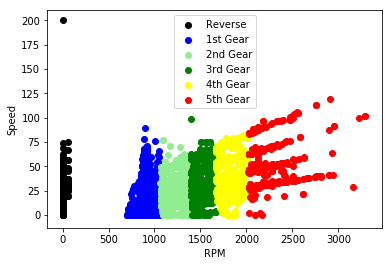

In [26]:
two_variables_with_cluster_color_simple(car_data, col_x_axis='RPM',col_y_axis='Speed')

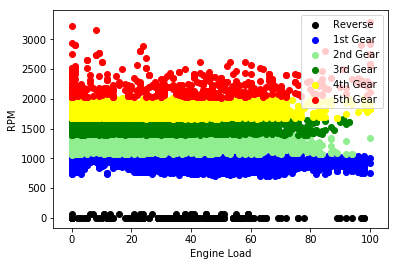

In [27]:
two_variables_with_cluster_color_simple(car_data, col_x_axis='Engine Load',col_y_axis='RPM')

### reducing dimensionality and plotting

In [28]:
from sklearn.decomposition import PCA as sklearnPCA

In [29]:
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(car_data[list_of_relevant_cols]))
transformed['gear_labels'] =car_data["gear_labels"]

In [30]:
transformed.head()

,0,1,gear_labels
0,-326.586687,-15.819617,1st gear
1,-326.586687,-15.819617,1st gear
2,-307.803808,-6.163940,1st gear
3,-307.803808,-6.163940,1st gear
4,-450.754842,-11.138056,1st gear


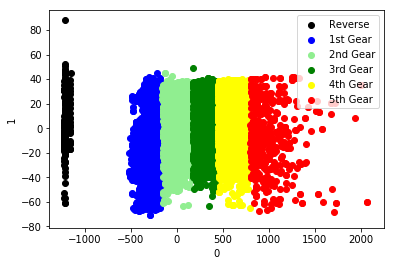

In [31]:
two_variables_with_cluster_color_simple(transformed, col_x_axis=0,col_y_axis=1)

In [32]:
car_data_raw['gear_labels'] = car_data['gear_labels']

In [33]:
car_data_raw.to_csv("car_data_with_gear_labels.csv", index=False)